# How to train your DragoNN tutorial 2: 
## CNN Hyperparameter Tuning via Grid Search 
This tutorial is a supplement to the DragoNN manuscript and follows figure 6 in the manuscript. 

This tutorial will take 2 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Define default CNN architecture helper utilities</a></li> 
    <li><a href=#3>Data simulation and default CNN model performance</a></li>
    <ol>
        <li><a href=#3a>Simple Motif Detection: TAL1, CTCF, ZNF143, SIX5 </a></li>
        <li><a href=#3b>Motif Density Detection</a></li>
        <li><a href=#3c>Motif Density Localization</a></li>
        <li><a href=#3d>Multiple Motif Detection</a></li>
        <li><a href=#3e>Heterodimer Motif Grammar: SPI1_IRF</a></li>
    </ol>
    <li><a href=#4>Hyperparameter grid search</a></li>
    <ol>
    <li><a href=#4a>Training examples</a></li>
    <li><a href=#4b>Convolutional Filter Width </a></li>  
    <li><a href=#4c>Number of convolution filters</a></li>
    <li><a href=#4d>Max Pooling Width</a></li>
    </ol>
    <li><a href=#5>Conclusions</a></li>
</ol>

Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

In this tutorial, we will perform a grid search to tune hyperparameter values for binary classification models trained on a variety of simulated datasets. 
We will examine the number of training data points used, convolutional filter width, the number of convolutional filters in the modle, and the width of the max-pooling layer. Each of these parameters will be systematically varied from low to high at a fixed interval, and the model's auROC on the held-out test set will be measured. 

This approach follows the discussion in the accompanying DragoNN primer (Figure 6). However, it is not the only way to tune parameters. A common alternative involved random hyperparameter tuning, where random combinations of hyperparameter values are tried and the resulting loss or auROC on the test set is measured.  Accepted ranges for the random parameter values are progressively reduced as we traverse the search space. 

In practice, the grid search approach is more thorough and less prone to finding local minima in the loss, and we will restrict this tutorial to this approach.  However, it is also more time consuming than random search, and it is important to keep this tradeoff in mind when selecting the parameter tuning approach on your dataset. 


## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./tutorial_images/inspecting_code.png)


In [3]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [4]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [5]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Define basic CNN architecture helper utilities <a name='2'>
<a href=#outline>Home</a>


We start with a simple reference CNN architecture that contains a convolutional layer with 10 convolutional filters (size 15, stride 1) and ReLU activations, followed by max-pooling (size 35,stride 35), followed by a fully connected layer with a logistic output neuron for binary classification. Models are trained using the Adam optimizer with early stopping after 7 consecutive epochs without validation loss improvement. Performance (auROC) is recorded on an the independent test set.

We will initialize multiple models with this basic architecture, so we write helper functions to generate the architecture, perform training, print the loss curve, and print test set auROC. 

In [6]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')
from dragonn.utils import * 

Using TensorFlow backend.


In [7]:
def build_default_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model 


In [12]:
from dragonn.callbacks import * 
from dragonn.vis import plot_learning_curve 

def train_default_model(data,num_tasks,model_constructor=build_default_model):
    
    #Build the model 
    model=model_constructor(data.X_train.shape[1::],num_tasks)
    
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),
                                 validation_data=(data.X_valid,data.y_valid))
    #Train the Model
    history=model.fit(x=data.X_train,y=data.y_train,
                      batch_size=128,
                      epochs=150,
                      verbose=0,
                      callbacks=[EarlyStopping(patience=7,restore_best_weights=True),
                                 History(),
                                 metrics_callback],
                      validation_data=(data.X_valid,data.y_valid))
    #Plot the learning curve
    plot_learning_curve(history)
    
    #Print model performance on held-out test set
    print("Test Set Performance:")
    test_predictions=model.predict(data.X_test)
    print(ClassificationResult(data.y_test,test_predictions))

    #return the trained model and history 
    return model,history


## Data simulation and basic architecture performance <a name='3'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [13]:
from dragonn.simulations import * 
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


We design four single-task binary classification tasks using DNA sequences that simulate different
properties of regulatory DNA sequences: single motif, homotypic motif clusters, heterotypic motif
clusters, and heterodimer motif grammars with spatial constraints. We further design a multitask
classification simulation to jointly detect motif instances of 3 distinct TFs (corresponding to 3 binary
classification tasks, one per TF). In each simulation, we embed motif instances with the relevant
constraints in random sequences (G/C frequency = 0.4). We hold out 20% of sequences for a test
set, 16% for a validation set, and use the remaining sequences for training. Motif instances are
reverse complemented with 0.5 probability before they are embedded in the background sequence.

We train models with the default architecture for these 4 individual TF simulations and evaluate the models' performance: 

### Simple Motif Detection: <a name='3a'>
<a href=#outline>Home</a>

TAL1_Known4: 
![TAL1_Known4](./tutorial_images/TAL1_known4.png)

Training Data:
Loss: 0.6949	Balanced Accuracy: 51.18%	 auROC: 0.516	 auPRC Careful: 0.517	 auPRC Trapezoidal: 0.517
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.6944	Balanced Accuracy: 51.22%	 auROC: 0.521	 auPRC Careful: 0.509	 auPRC Trapezoidal: 0.508
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.6925	Balanced Accuracy: 52.30%	 auROC: 0.534	 auPRC Careful: 0.532	 auPRC Trapezoidal: 0.532
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.6937	Balanced Accuracy: 51.27%	 auROC: 0.524	 auPRC Careful: 0.513	 auPRC Trapezoidal: 0.513
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.6896	Balanced Accuracy: 53.70%	 auROC: 0.549	 auPRC Careful: 0.545	 auPRC Trapezoidal: 0.545
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.1%	 Num Positives: 6435	 Num Negatives: 6

Training Data:
Loss: 0.4586	Balanced Accuracy: 82.97%	 auROC: 0.898	 auPRC Careful: 0.890	 auPRC Trapezoidal: 0.890
	Recall at 5%|10%|20% FDR: 24.9%|58.4%|87.5%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.4841	Balanced Accuracy: 81.15%	 auROC: 0.876	 auPRC Careful: 0.849	 auPRC Trapezoidal: 0.848
	Recall at 5%|10%|20% FDR: 0.0%|28.6%|81.9%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4448	Balanced Accuracy: 83.29%	 auROC: 0.904	 auPRC Careful: 0.897	 auPRC Trapezoidal: 0.897
	Recall at 5%|10%|20% FDR: 28.4%|63.9%|89.3%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.4702	Balanced Accuracy: 81.17%	 auROC: 0.883	 auPRC Careful: 0.856	 auPRC Trapezoidal: 0.856
	Recall at 5%|10%|20% FDR: 0.0%|30.2%|83.6%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4326	Balanced Accuracy: 83.88%	 auROC: 0.907	 auPRC Careful: 0.900	 auPRC Trapezoidal: 0.900
	Recall at 5%|10%|20% FDR: 29.7%|66.0%|90.1%	 Num Positives: 6435	 Num

Training Data:
Loss: 0.3154	Balanced Accuracy: 89.52%	 auROC: 0.942	 auPRC Careful: 0.940	 auPRC Trapezoidal: 0.940
	Recall at 5%|10%|20% FDR: 63.5%|87.8%|94.7%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.3485	Balanced Accuracy: 88.21%	 auROC: 0.927	 auPRC Careful: 0.913	 auPRC Trapezoidal: 0.913
	Recall at 5%|10%|20% FDR: 4.0%|79.5%|94.9%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.3125	Balanced Accuracy: 89.56%	 auROC: 0.943	 auPRC Careful: 0.940	 auPRC Trapezoidal: 0.940
	Recall at 5%|10%|20% FDR: 64.0%|88.2%|94.8%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.3458	Balanced Accuracy: 88.27%	 auROC: 0.927	 auPRC Careful: 0.914	 auPRC Trapezoidal: 0.914
	Recall at 5%|10%|20% FDR: 4.0%|79.1%|94.9%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.3092	Balanced Accuracy: 89.62%	 auROC: 0.943	 auPRC Careful: 0.941	 auPRC Trapezoidal: 0.941
	Recall at 5%|10%|20% FDR: 64.5%|88.5%|94.8%	 Num Positives: 6435	 Num

Training Data:
Loss: 0.2824	Balanced Accuracy: 90.57%	 auROC: 0.950	 auPRC Careful: 0.948	 auPRC Trapezoidal: 0.948
	Recall at 5%|10%|20% FDR: 68.3%|91.6%|95.3%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.3253	Balanced Accuracy: 88.62%	 auROC: 0.932	 auPRC Careful: 0.922	 auPRC Trapezoidal: 0.922
	Recall at 5%|10%|20% FDR: 53.1%|82.6%|94.9%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.2812	Balanced Accuracy: 90.68%	 auROC: 0.950	 auPRC Careful: 0.948	 auPRC Trapezoidal: 0.948
	Recall at 5%|10%|20% FDR: 68.2%|91.6%|95.4%	 Num Positives: 6435	 Num Negatives: 6365
Validation Data:
Loss: 0.3251	Balanced Accuracy: 88.72%	 auROC: 0.932	 auPRC Careful: 0.922	 auPRC Trapezoidal: 0.922
	Recall at 5%|10%|20% FDR: 53.7%|82.7%|94.9%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.2804	Balanced Accuracy: 90.70%	 auROC: 0.950	 auPRC Careful: 0.948	 auPRC Trapezoidal: 0.948
	Recall at 5%|10%|20% FDR: 68.9%|91.7%|95.4%	 Num Positives: 6435	 N

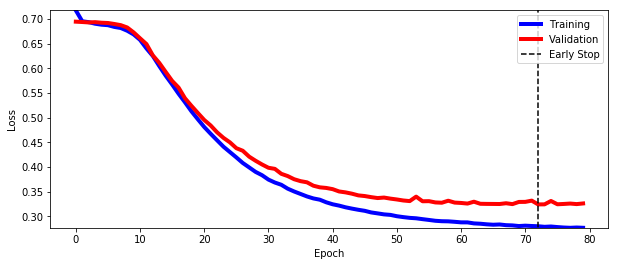

Test Set Performance:
Loss: 0.3415	Balanced Accuracy: 88.30%	 auROC: 0.924	 auPRC Careful: 0.916	 auPRC Trapezoidal: 0.916
	Recall at 5%|10%|20% FDR: 19.9%|80.8%|93.6%	 Num Positives: 1983	 Num Negatives: 2017


In [14]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
tal1_default_model,tal1_default_history=train_default_model(tal1_data,1)

CTCF_Known1: 
![CTCF_Known1](./tutorial_images/CTCF_known1.png)

Training Data:
Loss: 0.6934	Balanced Accuracy: 52.27%	 auROC: 0.532	 auPRC Careful: 0.532	 auPRC Trapezoidal: 0.532
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.2%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.6982	Balanced Accuracy: 49.81%	 auROC: 0.495	 auPRC Careful: 0.497	 auPRC Trapezoidal: 0.497
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.6881	Balanced Accuracy: 54.28%	 auROC: 0.557	 auPRC Careful: 0.554	 auPRC Trapezoidal: 0.554
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.6962	Balanced Accuracy: 49.37%	 auROC: 0.506	 auPRC Careful: 0.507	 auPRC Trapezoidal: 0.507
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.2%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.6828	Balanced Accuracy: 56.21%	 auROC: 0.586	 auPRC Careful: 0.581	 auPRC Trapezoidal: 0.581
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|0.3%	 Num Positives: 6449	 Num Negatives: 6

Training Data:
Loss: 0.3398	Balanced Accuracy: 87.47%	 auROC: 0.938	 auPRC Careful: 0.943	 auPRC Trapezoidal: 0.943
	Recall at 5%|10%|20% FDR: 71.4%|84.5%|92.6%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.3641	Balanced Accuracy: 86.39%	 auROC: 0.922	 auPRC Careful: 0.927	 auPRC Trapezoidal: 0.927
	Recall at 5%|10%|20% FDR: 65.3%|81.4%|89.5%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.3355	Balanced Accuracy: 87.55%	 auROC: 0.939	 auPRC Careful: 0.945	 auPRC Trapezoidal: 0.945
	Recall at 5%|10%|20% FDR: 72.9%|85.0%|92.7%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.3615	Balanced Accuracy: 86.59%	 auROC: 0.923	 auPRC Careful: 0.929	 auPRC Trapezoidal: 0.929
	Recall at 5%|10%|20% FDR: 65.6%|81.5%|89.5%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.3256	Balanced Accuracy: 88.02%	 auROC: 0.941	 auPRC Careful: 0.947	 auPRC Trapezoidal: 0.947
	Recall at 5%|10%|20% FDR: 73.9%|85.5%|92.9%	 Num Positives: 6449	 N

Training Data:
Loss: 0.2614	Balanced Accuracy: 90.14%	 auROC: 0.957	 auPRC Careful: 0.964	 auPRC Trapezoidal: 0.964
	Recall at 5%|10%|20% FDR: 83.0%|90.0%|95.0%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.3110	Balanced Accuracy: 88.38%	 auROC: 0.932	 auPRC Careful: 0.944	 auPRC Trapezoidal: 0.944
	Recall at 5%|10%|20% FDR: 76.6%|85.9%|91.1%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.2594	Balanced Accuracy: 90.10%	 auROC: 0.958	 auPRC Careful: 0.965	 auPRC Trapezoidal: 0.965
	Recall at 5%|10%|20% FDR: 83.3%|90.1%|94.9%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.3104	Balanced Accuracy: 88.40%	 auROC: 0.933	 auPRC Careful: 0.945	 auPRC Trapezoidal: 0.945
	Recall at 5%|10%|20% FDR: 76.7%|85.9%|90.9%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.2563	Balanced Accuracy: 90.34%	 auROC: 0.958	 auPRC Careful: 0.965	 auPRC Trapezoidal: 0.965
	Recall at 5%|10%|20% FDR: 83.5%|90.3%|94.9%	 Num Positives: 6449	 N

Training Data:
Loss: 0.2181	Balanced Accuracy: 92.37%	 auROC: 0.968	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 89.5%|93.0%|95.9%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.2771	Balanced Accuracy: 90.07%	 auROC: 0.941	 auPRC Careful: 0.955	 auPRC Trapezoidal: 0.955
	Recall at 5%|10%|20% FDR: 82.8%|88.6%|92.3%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.2165	Balanced Accuracy: 92.38%	 auROC: 0.968	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 89.7%|93.1%|95.8%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.2764	Balanced Accuracy: 90.05%	 auROC: 0.942	 auPRC Careful: 0.956	 auPRC Trapezoidal: 0.956
	Recall at 5%|10%|20% FDR: 83.1%|88.7%|92.3%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.2147	Balanced Accuracy: 92.50%	 auROC: 0.969	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 89.6%|93.3%|95.9%	 Num Positives: 6449	 N

Training Data:
Loss: nan	Balanced Accuracy: 93.49%	 auROC: 0.974	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 91.8%|94.1%|96.5%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: 0.2545	Balanced Accuracy: 90.99%	 auROC: 0.947	 auPRC Careful: 0.961	 auPRC Trapezoidal: 0.961
	Recall at 5%|10%|20% FDR: 86.4%|90.0%|92.4%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: nan	Balanced Accuracy: 93.54%	 auROC: 0.974	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 91.8%|94.1%|96.5%	 Num Positives: 6449	 Num Negatives: 6351
Validation Data:
Loss: nan	Balanced Accuracy: 90.90%	 auROC: 0.947	 auPRC Careful: 0.961	 auPRC Trapezoidal: 0.961
	Recall at 5%|10%|20% FDR: 86.7%|90.1%|92.5%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: nan	Balanced Accuracy: 93.61%	 auROC: 0.974	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 91.9%|94.1%|96.6%	 Num Positives: 6449	 Num Negatives

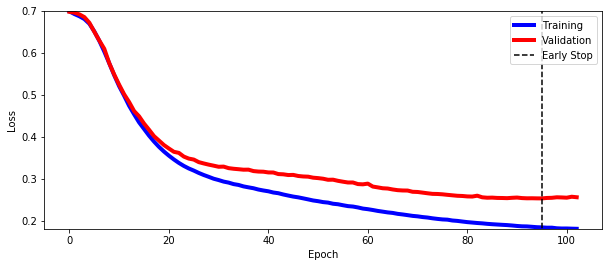

Test Set Performance:
Loss: nan	Balanced Accuracy: 92.29%	 auROC: 0.958	 auPRC Careful: 0.967	 auPRC Trapezoidal: 0.967
	Recall at 5%|10%|20% FDR: 89.1%|92.8%|94.7%	 Num Positives: 1975	 Num Negatives: 2025


In [15]:
#Define simulation parameters 
ctcf_parameters = {
    "motif_name": "CTCF_known1",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
ctcf_data = get_simulation_data("simulate_single_motif_detection",
                                      ctcf_parameters,
                                      validation_set_size=3200, test_set_size=4000)

#Train default model 
ctcf_default_model,ctcf_default_history=train_default_model(ctcf_data,1)

ZNF143_known2: 
![ZNF143_known2](./tutorial_images/ZNF143_known2.png)

Training Data:
Loss: 0.6967	Balanced Accuracy: 50.98%	 auROC: 0.513	 auPRC Careful: 0.512	 auPRC Trapezoidal: 0.512
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.7013	Balanced Accuracy: 48.46%	 auROC: 0.488	 auPRC Careful: 0.491	 auPRC Trapezoidal: 0.490
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.6931	Balanced Accuracy: 52.24%	 auROC: 0.531	 auPRC Careful: 0.526	 auPRC Trapezoidal: 0.526
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.6990	Balanced Accuracy: 50.11%	 auROC: 0.496	 auPRC Careful: 0.497	 auPRC Trapezoidal: 0.496
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.6906	Balanced Accuracy: 52.85%	 auROC: 0.547	 auPRC Careful: 0.538	 auPRC Trapezoidal: 0.538
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6391	 Num Negatives: 6

Training Data:
Loss: 0.5208	Balanced Accuracy: 76.54%	 auROC: 0.868	 auPRC Careful: 0.863	 auPRC Trapezoidal: 0.863
	Recall at 5%|10%|20% FDR: 21.1%|47.5%|77.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5540	Balanced Accuracy: 72.59%	 auROC: 0.824	 auPRC Careful: 0.823	 auPRC Trapezoidal: 0.822
	Recall at 5%|10%|20% FDR: 15.4%|31.4%|61.6%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.4993	Balanced Accuracy: 79.21%	 auROC: 0.878	 auPRC Careful: 0.873	 auPRC Trapezoidal: 0.873
	Recall at 5%|10%|20% FDR: 24.0%|51.7%|79.8%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5315	Balanced Accuracy: 75.77%	 auROC: 0.838	 auPRC Careful: 0.836	 auPRC Trapezoidal: 0.836
	Recall at 5%|10%|20% FDR: 15.9%|35.4%|66.5%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.4839	Balanced Accuracy: 80.10%	 auROC: 0.889	 auPRC Careful: 0.884	 auPRC Trapezoidal: 0.884
	Recall at 5%|10%|20% FDR: 29.4%|57.1%|83.1%	 Num Positives: 6391	 N

Training Data:
Loss: 0.2829	Balanced Accuracy: 90.75%	 auROC: 0.955	 auPRC Careful: 0.957	 auPRC Trapezoidal: 0.957
	Recall at 5%|10%|20% FDR: 85.4%|90.5%|94.5%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.3120	Balanced Accuracy: 89.68%	 auROC: 0.940	 auPRC Careful: 0.948	 auPRC Trapezoidal: 0.948
	Recall at 5%|10%|20% FDR: 80.4%|88.3%|93.3%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.2789	Balanced Accuracy: 90.50%	 auROC: 0.956	 auPRC Careful: 0.958	 auPRC Trapezoidal: 0.958
	Recall at 5%|10%|20% FDR: 85.5%|90.6%|94.5%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.3072	Balanced Accuracy: 88.97%	 auROC: 0.941	 auPRC Careful: 0.949	 auPRC Trapezoidal: 0.949
	Recall at 5%|10%|20% FDR: 81.2%|88.4%|93.3%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.2741	Balanced Accuracy: 90.70%	 auROC: 0.956	 auPRC Careful: 0.958	 auPRC Trapezoidal: 0.958
	Recall at 5%|10%|20% FDR: 85.6%|90.6%|94.6%	 Num Positives: 6391	 N

Training Data:
Loss: 0.2210	Balanced Accuracy: 92.27%	 auROC: 0.968	 auPRC Careful: 0.970	 auPRC Trapezoidal: 0.970
	Recall at 5%|10%|20% FDR: 88.7%|93.0%|96.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.2600	Balanced Accuracy: 90.81%	 auROC: 0.949	 auPRC Careful: 0.960	 auPRC Trapezoidal: 0.960
	Recall at 5%|10%|20% FDR: 86.9%|90.3%|94.0%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.2203	Balanced Accuracy: 92.20%	 auROC: 0.968	 auPRC Careful: 0.971	 auPRC Trapezoidal: 0.971
	Recall at 5%|10%|20% FDR: 89.1%|93.0%|96.2%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.2603	Balanced Accuracy: 90.81%	 auROC: 0.950	 auPRC Careful: 0.961	 auPRC Trapezoidal: 0.961
	Recall at 5%|10%|20% FDR: 86.8%|90.3%|94.1%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.2184	Balanced Accuracy: 92.43%	 auROC: 0.968	 auPRC Careful: 0.971	 auPRC Trapezoidal: 0.971
	Recall at 5%|10%|20% FDR: 89.1%|93.1%|96.2%	 Num Positives: 6391	 N

Training Data:
Loss: 0.1887	Balanced Accuracy: 93.63%	 auROC: 0.976	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 92.2%|94.5%|96.9%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.2312	Balanced Accuracy: 92.04%	 auROC: 0.957	 auPRC Careful: 0.969	 auPRC Trapezoidal: 0.969
	Recall at 5%|10%|20% FDR: 89.7%|92.6%|94.5%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.1841	Balanced Accuracy: 93.75%	 auROC: 0.976	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 92.3%|94.7%|97.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.2283	Balanced Accuracy: 92.56%	 auROC: 0.957	 auPRC Careful: 0.969	 auPRC Trapezoidal: 0.969
	Recall at 5%|10%|20% FDR: 89.8%|92.6%|94.5%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.1825	Balanced Accuracy: 93.80%	 auROC: 0.976	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 92.4%|94.6%|96.9%	 Num Positives: 6391	 N

Training Data:
Loss: 0.1624	Balanced Accuracy: 94.65%	 auROC: 0.980	 auPRC Careful: 0.984	 auPRC Trapezoidal: 0.984
	Recall at 5%|10%|20% FDR: 93.5%|95.2%|97.2%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.2109	Balanced Accuracy: 93.53%	 auROC: 0.960	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 91.3%|92.9%|94.7%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.1621	Balanced Accuracy: 94.51%	 auROC: 0.980	 auPRC Careful: 0.984	 auPRC Trapezoidal: 0.984
	Recall at 5%|10%|20% FDR: 93.5%|95.3%|97.3%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.2094	Balanced Accuracy: 93.21%	 auROC: 0.961	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 91.3%|93.0%|94.7%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: 0.1617	Balanced Accuracy: 94.65%	 auROC: 0.980	 auPRC Careful: 0.984	 auPRC Trapezoidal: 0.984
	Recall at 5%|10%|20% FDR: 93.5%|95.3%|97.3%	 Num Positives: 6391	 N

Training Data:
Loss: nan	Balanced Accuracy: 95.16%	 auROC: 0.983	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 94.2%|95.8%|97.6%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: nan	Balanced Accuracy: 93.96%	 auROC: 0.962	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 92.4%|93.1%|94.6%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: nan	Balanced Accuracy: 95.30%	 auROC: 0.984	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 94.2%|95.8%|97.7%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: nan	Balanced Accuracy: 94.24%	 auROC: 0.962	 auPRC Careful: 0.975	 auPRC Trapezoidal: 0.975
	Recall at 5%|10%|20% FDR: 92.2%|93.1%|94.7%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: nan	Balanced Accuracy: 95.37%	 auROC: 0.984	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 94.4%|95.9%|97.7%	 Num Positives: 6391	 Num Negatives: 6

Training Data:
Loss: nan	Balanced Accuracy: 95.65%	 auROC: 0.986	 auPRC Careful: 0.988	 auPRC Trapezoidal: 0.988
	Recall at 5%|10%|20% FDR: 94.9%|96.4%|98.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.1896	Balanced Accuracy: 94.53%	 auROC: 0.963	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 92.5%|93.3%|94.8%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: nan	Balanced Accuracy: 95.60%	 auROC: 0.986	 auPRC Careful: 0.988	 auPRC Trapezoidal: 0.988
	Recall at 5%|10%|20% FDR: 94.9%|96.3%|98.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: nan	Balanced Accuracy: 94.30%	 auROC: 0.963	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 92.5%|93.3%|94.9%	 Num Positives: 1615	 Num Negatives: 1585
Training Data:
Loss: nan	Balanced Accuracy: 95.64%	 auROC: 0.986	 auPRC Careful: 0.988	 auPRC Trapezoidal: 0.988
	Recall at 5%|10%|20% FDR: 94.9%|96.4%|98.0%	 Num Positives: 6391	 Num Negatives

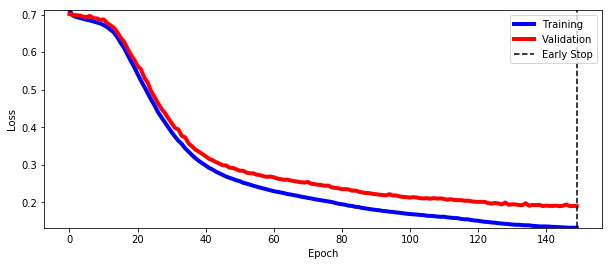

Test Set Performance:
Loss: 0.1943	Balanced Accuracy: 94.27%	 auROC: 0.961	 auPRC Careful: 0.974	 auPRC Trapezoidal: 0.974
	Recall at 5%|10%|20% FDR: 92.1%|92.9%|94.1%	 Num Positives: 1994	 Num Negatives: 2006


In [16]:
#Define simulation parameters 
znf143_parameters={
    "motif_name": "ZNF143_known2",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data 
znf143_data=get_simulation_data("simulate_single_motif_detection",
                               znf143_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
znf143_default_model,znf143_default_history=train_default_model(znf143_data,1)

SIX5_known1:  
![SIX5_known1](./tutorial_images/SIX5_known1.png) 

Training Data:
Loss: 0.6990	Balanced Accuracy: 50.00%	 auROC: 0.505	 auPRC Careful: 0.506	 auPRC Trapezoidal: 0.506
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.7028	Balanced Accuracy: 48.97%	 auROC: 0.488	 auPRC Careful: 0.485	 auPRC Trapezoidal: 0.485
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.7017	Balanced Accuracy: 50.94%	 auROC: 0.524	 auPRC Careful: 0.521	 auPRC Trapezoidal: 0.521
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.7078	Balanced Accuracy: 49.73%	 auROC: 0.489	 auPRC Careful: 0.485	 auPRC Trapezoidal: 0.485
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.6917	Balanced Accuracy: 52.37%	 auROC: 0.539	 auPRC Careful: 0.533	 auPRC Trapezoidal: 0.533
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.2%	 Num Positives: 6391	 Num Negatives: 6

Training Data:
Loss: 0.6373	Balanced Accuracy: 64.84%	 auROC: 0.709	 auPRC Careful: 0.704	 auPRC Trapezoidal: 0.704
	Recall at 5%|10%|20% FDR: 1.8%|3.0%|21.9%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.6685	Balanced Accuracy: 59.60%	 auROC: 0.626	 auPRC Careful: 0.615	 auPRC Trapezoidal: 0.615
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|3.4%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.6375	Balanced Accuracy: 63.78%	 auROC: 0.720	 auPRC Careful: 0.714	 auPRC Trapezoidal: 0.714
	Recall at 5%|10%|20% FDR: 1.0%|4.9%|25.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.6692	Balanced Accuracy: 59.00%	 auROC: 0.637	 auPRC Careful: 0.626	 auPRC Trapezoidal: 0.626
	Recall at 5%|10%|20% FDR: 0.1%|1.4%|4.4%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.6262	Balanced Accuracy: 66.01%	 auROC: 0.730	 auPRC Careful: 0.723	 auPRC Trapezoidal: 0.723
	Recall at 5%|10%|20% FDR: 1.4%|6.4%|27.2%	 Num Positives: 6391	 Num Negatives

Training Data:
Loss: 0.5192	Balanced Accuracy: 75.77%	 auROC: 0.836	 auPRC Careful: 0.823	 auPRC Trapezoidal: 0.823
	Recall at 5%|10%|20% FDR: 2.5%|26.4%|67.5%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5670	Balanced Accuracy: 71.95%	 auROC: 0.785	 auPRC Careful: 0.765	 auPRC Trapezoidal: 0.765
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|53.7%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.5169	Balanced Accuracy: 75.83%	 auROC: 0.839	 auPRC Careful: 0.827	 auPRC Trapezoidal: 0.827
	Recall at 5%|10%|20% FDR: 2.5%|27.6%|68.8%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5648	Balanced Accuracy: 72.36%	 auROC: 0.788	 auPRC Careful: 0.769	 auPRC Trapezoidal: 0.769
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|56.4%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.5106	Balanced Accuracy: 76.88%	 auROC: 0.841	 auPRC Careful: 0.829	 auPRC Trapezoidal: 0.829
	Recall at 5%|10%|20% FDR: 2.5%|27.6%|70.0%	 Num Positives: 6391	 Num Nega

Training Data:
Loss: 0.4664	Balanced Accuracy: 79.55%	 auROC: 0.866	 auPRC Careful: 0.857	 auPRC Trapezoidal: 0.857
	Recall at 5%|10%|20% FDR: 5.7%|46.1%|78.5%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5226	Balanced Accuracy: 77.12%	 auROC: 0.822	 auPRC Careful: 0.809	 auPRC Trapezoidal: 0.809
	Recall at 5%|10%|20% FDR: 3.8%|13.1%|70.4%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4644	Balanced Accuracy: 79.65%	 auROC: 0.866	 auPRC Careful: 0.858	 auPRC Trapezoidal: 0.858
	Recall at 5%|10%|20% FDR: 5.7%|47.1%|79.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5205	Balanced Accuracy: 77.10%	 auROC: 0.822	 auPRC Careful: 0.810	 auPRC Trapezoidal: 0.810
	Recall at 5%|10%|20% FDR: 2.8%|13.1%|70.6%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4664	Balanced Accuracy: 79.01%	 auROC: 0.867	 auPRC Careful: 0.860	 auPRC Trapezoidal: 0.860
	Recall at 5%|10%|20% FDR: 5.5%|48.8%|79.3%	 Num Positives: 6391	 Num Ne

Training Data:
Loss: 0.4475	Balanced Accuracy: 80.48%	 auROC: 0.877	 auPRC Careful: 0.871	 auPRC Trapezoidal: 0.871
	Recall at 5%|10%|20% FDR: 7.7%|56.0%|81.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5149	Balanced Accuracy: 77.60%	 auROC: 0.831	 auPRC Careful: 0.824	 auPRC Trapezoidal: 0.824
	Recall at 5%|10%|20% FDR: 5.1%|19.2%|73.3%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4451	Balanced Accuracy: 80.31%	 auROC: 0.878	 auPRC Careful: 0.872	 auPRC Trapezoidal: 0.872
	Recall at 5%|10%|20% FDR: 7.9%|56.7%|81.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5097	Balanced Accuracy: 77.63%	 auROC: 0.830	 auPRC Careful: 0.825	 auPRC Trapezoidal: 0.825
	Recall at 5%|10%|20% FDR: 4.6%|26.7%|73.2%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4527	Balanced Accuracy: 79.70%	 auROC: 0.878	 auPRC Careful: 0.873	 auPRC Trapezoidal: 0.873
	Recall at 5%|10%|20% FDR: 8.8%|57.3%|81.0%	 Num Positives: 6391	 Num Ne

Training Data:
Loss: 0.4347	Balanced Accuracy: 80.52%	 auROC: 0.883	 auPRC Careful: 0.879	 auPRC Trapezoidal: 0.879
	Recall at 5%|10%|20% FDR: 21.7%|59.8%|82.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5056	Balanced Accuracy: 77.98%	 auROC: 0.834	 auPRC Careful: 0.832	 auPRC Trapezoidal: 0.832
	Recall at 5%|10%|20% FDR: 11.0%|25.3%|74.1%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4341	Balanced Accuracy: 80.93%	 auROC: 0.883	 auPRC Careful: 0.879	 auPRC Trapezoidal: 0.879
	Recall at 5%|10%|20% FDR: 23.7%|59.7%|82.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5067	Balanced Accuracy: 77.83%	 auROC: 0.835	 auPRC Careful: 0.833	 auPRC Trapezoidal: 0.833
	Recall at 5%|10%|20% FDR: 10.6%|25.9%|74.5%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4331	Balanced Accuracy: 80.92%	 auROC: 0.884	 auPRC Careful: 0.879	 auPRC Trapezoidal: 0.879
	Recall at 5%|10%|20% FDR: 21.5%|59.9%|82.2%	 Num Positives: 6391	 N

Training Data:
Loss: 0.4297	Balanced Accuracy: 81.33%	 auROC: 0.887	 auPRC Careful: 0.883	 auPRC Trapezoidal: 0.883
	Recall at 5%|10%|20% FDR: 29.7%|62.3%|83.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5060	Balanced Accuracy: 78.15%	 auROC: 0.838	 auPRC Careful: 0.838	 auPRC Trapezoidal: 0.838
	Recall at 5%|10%|20% FDR: 9.5%|38.3%|74.8%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4266	Balanced Accuracy: 81.33%	 auROC: 0.887	 auPRC Careful: 0.883	 auPRC Trapezoidal: 0.883
	Recall at 5%|10%|20% FDR: 30.0%|62.6%|83.3%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.5019	Balanced Accuracy: 78.28%	 auROC: 0.838	 auPRC Careful: 0.838	 auPRC Trapezoidal: 0.838
	Recall at 5%|10%|20% FDR: 9.4%|38.7%|74.8%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4266	Balanced Accuracy: 81.09%	 auROC: 0.888	 auPRC Careful: 0.884	 auPRC Trapezoidal: 0.884
	Recall at 5%|10%|20% FDR: 30.4%|62.8%|83.3%	 Num Positives: 6391	 Num

Training Data:
Loss: 0.4208	Balanced Accuracy: 81.47%	 auROC: 0.891	 auPRC Careful: 0.888	 auPRC Trapezoidal: 0.888
	Recall at 5%|10%|20% FDR: 35.3%|63.0%|84.0%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.4968	Balanced Accuracy: 78.39%	 auROC: 0.842	 auPRC Careful: 0.842	 auPRC Trapezoidal: 0.842
	Recall at 5%|10%|20% FDR: 10.1%|38.5%|75.0%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4211	Balanced Accuracy: 81.52%	 auROC: 0.891	 auPRC Careful: 0.887	 auPRC Trapezoidal: 0.887
	Recall at 5%|10%|20% FDR: 34.0%|62.5%|84.1%	 Num Positives: 6391	 Num Negatives: 6409
Validation Data:
Loss: 0.4979	Balanced Accuracy: 78.30%	 auROC: 0.842	 auPRC Careful: 0.842	 auPRC Trapezoidal: 0.842
	Recall at 5%|10%|20% FDR: 10.4%|38.6%|74.8%	 Num Positives: 1582	 Num Negatives: 1618
Training Data:
Loss: 0.4234	Balanced Accuracy: 81.72%	 auROC: 0.892	 auPRC Careful: 0.888	 auPRC Trapezoidal: 0.888
	Recall at 5%|10%|20% FDR: 35.8%|63.1%|84.0%	 Num Positives: 6391	 N

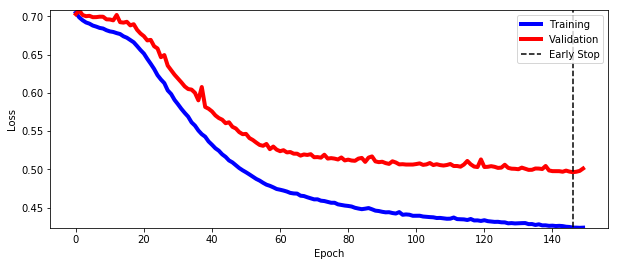

Test Set Performance:
Loss: 0.5295	Balanced Accuracy: 76.76%	 auROC: 0.827	 auPRC Careful: 0.825	 auPRC Trapezoidal: 0.824
	Recall at 5%|10%|20% FDR: 0.5%|29.1%|72.6%	 Num Positives: 2027	 Num Negatives: 1973


In [17]:
#Define simulation parameters 
six5_parameters={
    "motif_name": "SIX5_known1",
    "seq_length": 500,
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
six5_data=get_simulation_data("simulate_single_motif_detection",
                               six5_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
six5_default_model,six5_default_history=train_default_model(six5_data,1)

### Motif Density Detection <a name='3b'>
<a href=#outline>Home</a>

In this binary simulation task, we simulate 10K 500 bp random sequences with 0-2 instances of a TAL1 motif embedded at any random position and
10K 500 bp random sequences with 3-5 instances of the motif embedded at any random position. To solve this simulation, the model needs to learn the differences in motif counts.

In [18]:
print_simulation_info("simulate_motif_counting")



    Generates data for motif counting task.

    Parameters
    ----------
    motif_name : str
    seq_length : int
    pos_counts : list
        (min_counts, max_counts) for positive set.
    neg_counts : list
        (min_counts, max_counts) for negative set.
    num_pos : int
    num_neg : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darray
        Contains labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


Training Data:
Loss: 0.6845	Balanced Accuracy: 55.02%	 auROC: 0.585	 auPRC Careful: 0.580	 auPRC Trapezoidal: 0.580
	Recall at 5%|10%|20% FDR: 0.1%|0.2%|0.2%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.6861	Balanced Accuracy: 54.52%	 auROC: 0.572	 auPRC Careful: 0.570	 auPRC Trapezoidal: 0.569
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.6472	Balanced Accuracy: 66.98%	 auROC: 0.743	 auPRC Careful: 0.744	 auPRC Trapezoidal: 0.744
	Recall at 5%|10%|20% FDR: 1.3%|11.1%|35.7%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.6526	Balanced Accuracy: 64.69%	 auROC: 0.721	 auPRC Careful: 0.728	 auPRC Trapezoidal: 0.728
	Recall at 5%|10%|20% FDR: 3.6%|10.4%|32.1%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.5690	Balanced Accuracy: 78.94%	 auROC: 0.871	 auPRC Careful: 0.872	 auPRC Trapezoidal: 0.872
	Recall at 5%|10%|20% FDR: 33.1%|50.5%|76.8%	 Num Positives: 6395	 Num Negat

Training Data:
Loss: 0.2243	Balanced Accuracy: 90.84%	 auROC: 0.971	 auPRC Careful: 0.972	 auPRC Trapezoidal: 0.972
	Recall at 5%|10%|20% FDR: 82.8%|91.6%|97.1%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.2359	Balanced Accuracy: 89.60%	 auROC: 0.968	 auPRC Careful: 0.970	 auPRC Trapezoidal: 0.969
	Recall at 5%|10%|20% FDR: 81.5%|89.8%|97.1%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.2222	Balanced Accuracy: 90.90%	 auROC: 0.972	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 82.9%|91.8%|97.2%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.2341	Balanced Accuracy: 89.63%	 auROC: 0.968	 auPRC Careful: 0.970	 auPRC Trapezoidal: 0.970
	Recall at 5%|10%|20% FDR: 81.1%|90.1%|97.0%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.2206	Balanced Accuracy: 90.88%	 auROC: 0.972	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 83.3%|91.9%|97.3%	 Num Positives: 6395	 N

Training Data:
Loss: 0.1968	Balanced Accuracy: 92.01%	 auROC: 0.977	 auPRC Careful: 0.978	 auPRC Trapezoidal: 0.978
	Recall at 5%|10%|20% FDR: 87.5%|93.1%|98.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.2185	Balanced Accuracy: 90.50%	 auROC: 0.971	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 83.4%|91.5%|97.5%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1969	Balanced Accuracy: 91.81%	 auROC: 0.977	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 87.7%|93.3%|98.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.2186	Balanced Accuracy: 90.56%	 auROC: 0.971	 auPRC Careful: 0.973	 auPRC Trapezoidal: 0.973
	Recall at 5%|10%|20% FDR: 83.4%|91.3%|97.5%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1956	Balanced Accuracy: 91.92%	 auROC: 0.977	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 87.7%|93.4%|98.0%	 Num Positives: 6395	 N

Training Data:
Loss: 0.1732	Balanced Accuracy: 93.05%	 auROC: 0.982	 auPRC Careful: 0.983	 auPRC Trapezoidal: 0.983
	Recall at 5%|10%|20% FDR: 91.3%|94.8%|98.5%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.2053	Balanced Accuracy: 91.10%	 auROC: 0.974	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 86.2%|91.9%|97.3%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1742	Balanced Accuracy: 93.27%	 auROC: 0.982	 auPRC Careful: 0.984	 auPRC Trapezoidal: 0.984
	Recall at 5%|10%|20% FDR: 91.3%|94.9%|98.5%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.2079	Balanced Accuracy: 91.27%	 auROC: 0.974	 auPRC Careful: 0.976	 auPRC Trapezoidal: 0.976
	Recall at 5%|10%|20% FDR: 86.2%|91.8%|97.4%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1714	Balanced Accuracy: 93.29%	 auROC: 0.983	 auPRC Careful: 0.984	 auPRC Trapezoidal: 0.984
	Recall at 5%|10%|20% FDR: 91.4%|95.0%|98.5%	 Num Positives: 6395	 N

Training Data:
Loss: 0.1562	Balanced Accuracy: 93.83%	 auROC: 0.985	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 92.5%|95.7%|98.8%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1947	Balanced Accuracy: 91.97%	 auROC: 0.976	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 88.5%|92.4%|97.5%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1571	Balanced Accuracy: 93.89%	 auROC: 0.986	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 92.7%|95.7%|98.8%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1963	Balanced Accuracy: 92.24%	 auROC: 0.977	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 88.7%|92.5%|97.4%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1553	Balanced Accuracy: 93.77%	 auROC: 0.986	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 92.7%|95.8%|98.9%	 Num Positives: 6395	 N

Training Data:
Loss: 0.1412	Balanced Accuracy: 94.51%	 auROC: 0.988	 auPRC Careful: 0.989	 auPRC Trapezoidal: 0.989
	Recall at 5%|10%|20% FDR: 93.8%|96.3%|99.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1831	Balanced Accuracy: 92.07%	 auROC: 0.979	 auPRC Careful: 0.981	 auPRC Trapezoidal: 0.981
	Recall at 5%|10%|20% FDR: 89.8%|92.8%|97.6%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1409	Balanced Accuracy: 94.44%	 auROC: 0.988	 auPRC Careful: 0.989	 auPRC Trapezoidal: 0.989
	Recall at 5%|10%|20% FDR: 93.9%|96.4%|99.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1830	Balanced Accuracy: 92.23%	 auROC: 0.979	 auPRC Careful: 0.981	 auPRC Trapezoidal: 0.981
	Recall at 5%|10%|20% FDR: 89.8%|92.9%|97.6%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: 0.1400	Balanced Accuracy: 94.54%	 auROC: 0.988	 auPRC Careful: 0.989	 auPRC Trapezoidal: 0.989
	Recall at 5%|10%|20% FDR: 93.9%|96.4%|99.0%	 Num Positives: 6395	 N

Training Data:
Loss: 0.1324	Balanced Accuracy: 94.78%	 auROC: 0.989	 auPRC Careful: 0.990	 auPRC Trapezoidal: 0.990
	Recall at 5%|10%|20% FDR: 94.4%|97.0%|99.2%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1796	Balanced Accuracy: 92.33%	 auROC: 0.979	 auPRC Careful: 0.982	 auPRC Trapezoidal: 0.982
	Recall at 5%|10%|20% FDR: 89.8%|92.3%|97.9%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: nan	Balanced Accuracy: 94.59%	 auROC: 0.989	 auPRC Careful: 0.990	 auPRC Trapezoidal: 0.990
	Recall at 5%|10%|20% FDR: 94.3%|97.0%|99.2%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1813	Balanced Accuracy: 91.50%	 auROC: 0.980	 auPRC Careful: 0.982	 auPRC Trapezoidal: 0.982
	Recall at 5%|10%|20% FDR: 89.8%|92.3%|97.8%	 Num Positives: 1613	 Num Negatives: 1587
Training Data:
Loss: nan	Balanced Accuracy: 94.70%	 auROC: 0.989	 auPRC Careful: 0.990	 auPRC Trapezoidal: 0.990
	Recall at 5%|10%|20% FDR: 94.3%|97.0%|99.1%	 Num Positives: 6395	 Num Neg

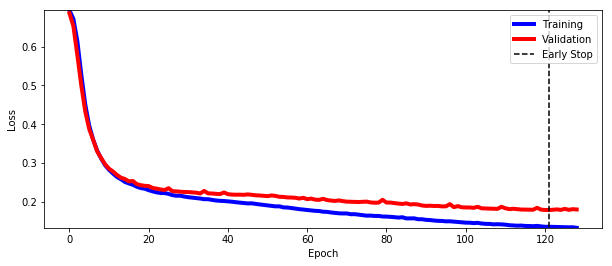

Test Set Performance:
Loss: 0.1881	Balanced Accuracy: 92.45%	 auROC: 0.978	 auPRC Careful: 0.980	 auPRC Trapezoidal: 0.980
	Recall at 5%|10%|20% FDR: 90.0%|92.5%|97.1%	 Num Positives: 1992	 Num Negatives: 2008


In [19]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_detection_default_model,density_detection_default_history=train_default_model(density_detection_data,1)

### Motif Density Localization <a name='3c'>
<a href=#outline>Home</a>

In this binary simulation task, we simulate 20K random sequences of length 1 Kbp with 2-4 embedded instances of the TAL1 motif. In the positive set of 10K sequences, the motif instances are embedded in the central 150bp. The negative set of 10K sequences, contain embedded motif instances at any random position. To solve this simulation, the model needs to learn localization differences of the motif instances.

In [20]:
print_simulation_info("simulate_motif_density_localization")



    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Training Data:
Loss: 0.6906	Balanced Accuracy: 52.72%	 auROC: 0.547	 auPRC Careful: 0.540	 auPRC Trapezoidal: 0.540
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.6963	Balanced Accuracy: 50.31%	 auROC: 0.509	 auPRC Careful: 0.511	 auPRC Trapezoidal: 0.511
	Recall at 5%|10%|20% FDR: 0.3%|0.3%|0.3%	 Num Positives: 1567	 Num Negatives: 1633
Training Data:
Loss: 0.6633	Balanced Accuracy: 62.19%	 auROC: 0.675	 auPRC Careful: 0.661	 auPRC Trapezoidal: 0.661
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|6.3%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.6723	Balanced Accuracy: 58.90%	 auROC: 0.633	 auPRC Careful: 0.622	 auPRC Trapezoidal: 0.621
	Recall at 5%|10%|20% FDR: 0.2%|0.2%|7.3%	 Num Positives: 1567	 Num Negatives: 1633
Training Data:
Loss: 0.5298	Balanced Accuracy: 83.91%	 auROC: 0.922	 auPRC Careful: 0.920	 auPRC Trapezoidal: 0.920
	Recall at 5%|10%|20% FDR: 50.0%|72.4%|89.2%	 Num Positives: 6395	 Num Negatives

Training Data:
Loss: 0.1103	Balanced Accuracy: 96.14%	 auROC: 0.993	 auPRC Careful: 0.992	 auPRC Trapezoidal: 0.992
	Recall at 5%|10%|20% FDR: 97.2%|99.4%|100.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1259	Balanced Accuracy: 95.45%	 auROC: 0.989	 auPRC Careful: 0.987	 auPRC Trapezoidal: 0.987
	Recall at 5%|10%|20% FDR: 95.3%|99.2%|99.8%	 Num Positives: 1567	 Num Negatives: 1633
Training Data:
Loss: 0.1078	Balanced Accuracy: 96.24%	 auROC: 0.993	 auPRC Careful: 0.992	 auPRC Trapezoidal: 0.992
	Recall at 5%|10%|20% FDR: 97.5%|99.4%|100.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1242	Balanced Accuracy: 95.48%	 auROC: 0.990	 auPRC Careful: 0.988	 auPRC Trapezoidal: 0.988
	Recall at 5%|10%|20% FDR: 95.6%|99.2%|99.9%	 Num Positives: 1567	 Num Negatives: 1633
Training Data:
Loss: 0.1076	Balanced Accuracy: 96.18%	 auROC: 0.993	 auPRC Careful: 0.992	 auPRC Trapezoidal: 0.992
	Recall at 5%|10%|20% FDR: 97.8%|99.5%|100.0%	 Num Positives: 6395

Training Data:
Loss: 0.0734	Balanced Accuracy: 97.59%	 auROC: 0.997	 auPRC Careful: 0.996	 auPRC Trapezoidal: 0.996
	Recall at 5%|10%|20% FDR: 99.3%|99.8%|100.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1082	Balanced Accuracy: 95.89%	 auROC: 0.992	 auPRC Careful: 0.990	 auPRC Trapezoidal: 0.990
	Recall at 5%|10%|20% FDR: 96.6%|99.4%|100.0%	 Num Positives: 1567	 Num Negatives: 1633
Training Data:
Loss: 0.0723	Balanced Accuracy: 97.64%	 auROC: 0.997	 auPRC Careful: 0.996	 auPRC Trapezoidal: 0.996
	Recall at 5%|10%|20% FDR: 99.3%|99.8%|100.0%	 Num Positives: 6395	 Num Negatives: 6405
Validation Data:
Loss: 0.1082	Balanced Accuracy: 95.89%	 auROC: 0.992	 auPRC Careful: 0.990	 auPRC Trapezoidal: 0.990
	Recall at 5%|10%|20% FDR: 96.6%|99.4%|100.0%	 Num Positives: 1567	 Num Negatives: 1633
Training Data:
Loss: 0.0715	Balanced Accuracy: 97.67%	 auROC: 0.997	 auPRC Careful: 0.996	 auPRC Trapezoidal: 0.996
	Recall at 5%|10%|20% FDR: 99.3%|99.8%|100.0%	 Num Positives: 63

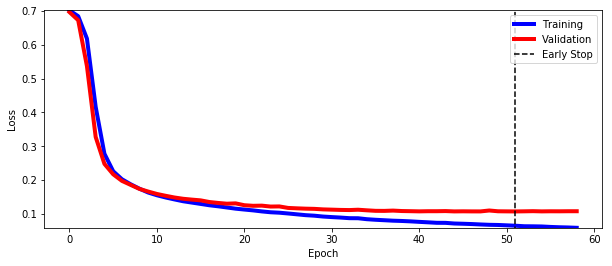

Test Set Performance:
Loss: 0.0963	Balanced Accuracy: 96.21%	 auROC: 0.994	 auPRC Careful: 0.994	 auPRC Trapezoidal: 0.994
	Recall at 5%|10%|20% FDR: 97.8%|99.6%|100.0%	 Num Positives: 2038	 Num Negatives: 1962


In [21]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
density_localization_default_model,density_localization_default_history=train_default_model(density_localization_data,1)

### Multiple Motif Detection <a name='3d'>
<a href=#outline>Home</a>

In this simulation of multiple co-binding TFs, we simulate 20K 500 bp random sequences. For each sequence, we independently embed 0 or 1 instance of motifs corresponding to 3 TFs: CTCF, ZNF143, and SIX5 (See SM). Each sequence has binary labels for 3 tasks corresponding to the presence/absence of a motif instance of each of the three TFs. We train a multitask CNN such as that the last layer of the model now has three output logistic neurons corresponding to the three separate tasks. To solve this simulation, the model needs to detect all three motifs while sharing parameters.

In [22]:
print_simulation_info("simulate_multi_motif_embedding")



    Generates data for multi motif recognition task.

    Parameters
    ----------
    motif_names : list
        List of strings.
    seq_length : int
    min_num_motifs : int
    max_num_motifs : int
    num_seqs : int
    GC_fraction : float

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : ndarray
        Contains labels for each motif.
    embedding_arr: 1darray
        Array of embedding objects.
    


Training Data:
Task 0: Loss: 0.4503	Balanced Accuracy: 50.00%	 auROC: 0.523	 auPRC Careful: 0.175	 auPRC Trapezoidal: 0.175
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2123	 Num Negatives: 10677
Task 1: Loss: 0.4565	Balanced Accuracy: 50.00%	 auROC: 0.515	 auPRC Careful: 0.178	 auPRC Trapezoidal: 0.178
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2169	 Num Negatives: 10631
Task 2: Loss: 0.4551	Balanced Accuracy: 50.00%	 auROC: 0.510	 auPRC Careful: 0.172	 auPRC Trapezoidal: 0.172
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 2157	 Num Negatives: 10643
Validation Data:
Task 0: Loss: 0.4548	Balanced Accuracy: 50.00%	 auROC: 0.495	 auPRC Careful: 0.164	 auPRC Trapezoidal: 0.163
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 533	 Num Negatives: 2667
Task 1: Loss: 0.4511	Balanced Accuracy: 50.00%	 auROC: 0.523	 auPRC Careful: 0.176	 auPRC Trapezoidal: 0.175
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 532	 Num Negatives: 2668
Ta

Training Data:
Task 0: Loss: 0.4437	Balanced Accuracy: 50.00%	 auROC: 0.593	 auPRC Careful: 0.219	 auPRC Trapezoidal: 0.218
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2123	 Num Negatives: 10677
Task 1: Loss: 0.4501	Balanced Accuracy: 50.00%	 auROC: 0.579	 auPRC Careful: 0.215	 auPRC Trapezoidal: 0.215
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2169	 Num Negatives: 10631
Task 2: Loss: 0.4498	Balanced Accuracy: 50.00%	 auROC: 0.572	 auPRC Careful: 0.205	 auPRC Trapezoidal: 0.205
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2157	 Num Negatives: 10643
Validation Data:
Task 0: Loss: 0.4536	Balanced Accuracy: 50.00%	 auROC: 0.506	 auPRC Careful: 0.174	 auPRC Trapezoidal: 0.173
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 533	 Num Negatives: 2667
Task 1: Loss: 0.4510	Balanced Accuracy: 50.00%	 auROC: 0.515	 auPRC Careful: 0.178	 auPRC Trapezoidal: 0.177
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 532	 Num Negatives: 2668
Ta

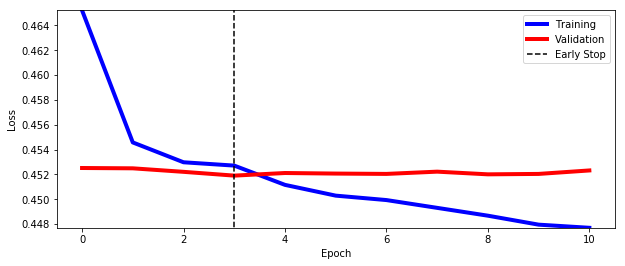

Test Set Performance:
Task 0: Loss: 0.4453	Balanced Accuracy: 50.00%	 auROC: 0.526	 auPRC Careful: 0.178	 auPRC Trapezoidal: 0.177
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 653	 Num Negatives: 3347
Task 1: Loss: 0.4639	Balanced Accuracy: 50.00%	 auROC: 0.499	 auPRC Careful: 0.173	 auPRC Trapezoidal: 0.172
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 692	 Num Negatives: 3308
Task 2: Loss: 0.4427	Balanced Accuracy: 50.00%	 auROC: 0.493	 auPRC Careful: 0.160	 auPRC Trapezoidal: 0.159
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 638	 Num Negatives: 3362


In [23]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)

#Train default model 
multi_motif_default_model,multi_motif_default_history=train_default_model(multi_motif_data,3)

### Heterodimer Motif Grammar <a name='3e'>
<a href=#outline>Home</a>

In this binary simulation task, we simulate 20K 500 bp random sequences with one instance of an SPI1 motif and one instance of an IRF motif. In the positive set of 10K sequences, the pair of motifs are embedded with a relative spacing of 2-5 bp between each other, at any random position in each sequence. In the negative set, the pair of motifs are both randomly embedded with no positional or spacing constraints. 

In [24]:
print_simulation_info("simulate_heterodimer_grammar")


    Simulates two classes of sequences with motif1 and motif2:
        - Positive class sequences with motif1 and motif2 positioned
          min_spacing and max_spacing
        - Negative class sequences with independent motif1 and motif2 positioned
        anywhere in the sequence, not as a heterodimer grammar

    Parameters
    ----------
    seq_length : int, length of sequence
    GC_fraction : float, GC fraction in background sequence
    num_pos : int, number of positive class sequences
    num_neg : int, number of negatice class sequences
    motif1 : str, encode motif name
    motif2 : str, encode motif name
    min_spacing : int, minimum inter motif spacing
    max_spacing : int, maximum inter motif spacing

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: list
        List of embedding objects.
    


In [25]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

To solve this simulation, the model needs to detect both motifs and learn the spacing constraint between them in the positive set. For this simulation, an architecture with a single convolutional layer does not perform well. Hence, we use a reference architecture with 3 convolutional layers. Each convolutional layer has 15 filters (size 15, stride 1) and ReLU-non-linearity, followed by max-pooling (size 35, stride 35), followed by a fully connected layer with sigmoid non-linearity for binary classification.

Training Data:
Loss: 0.6901	Balanced Accuracy: 54.96%	 auROC: 0.587	 auPRC Careful: 0.579	 auPRC Trapezoidal: 0.579
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6416	 Num Negatives: 6384
Validation Data:
Loss: 0.6935	Balanced Accuracy: 49.37%	 auROC: 0.503	 auPRC Careful: 0.503	 auPRC Trapezoidal: 0.503
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.6858	Balanced Accuracy: 55.90%	 auROC: 0.642	 auPRC Careful: 0.630	 auPRC Trapezoidal: 0.630
	Recall at 5%|10%|20% FDR: 0.0%|0.3%|1.8%	 Num Positives: 6416	 Num Negatives: 6384
Validation Data:
Loss: 0.6941	Balanced Accuracy: 50.62%	 auROC: 0.512	 auPRC Careful: 0.503	 auPRC Trapezoidal: 0.503
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1576	 Num Negatives: 1624
Training Data:
Loss: 0.6792	Balanced Accuracy: 61.74%	 auROC: 0.677	 auPRC Careful: 0.667	 auPRC Trapezoidal: 0.667
	Recall at 5%|10%|20% FDR: 0.0%|0.3%|6.4%	 Num Positives: 6416	 Num Negatives: 6

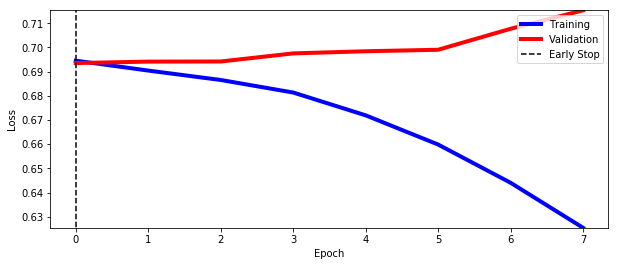

Test Set Performance:
Loss: 0.6917	Balanced Accuracy: 52.32%	 auROC: 0.542	 auPRC Careful: 0.537	 auPRC Trapezoidal: 0.537
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 2008	 Num Negatives: 1992


In [26]:
def build_heterodimer_model(input_shape,num_tasks): 
    model=Sequential()
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(1,35)))    
    model.add(Flatten())
    model.add(Dense(num_tasks))
    model.add(Activation("sigmoid"))
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model


#Train default model 
heterodimer_default_model,heterodimer_default_history=train_default_model(heterodimer_data,1,build_heterodimer_model)

Let's store the datasets we have generated in a dictionary to facilitate hyperparameter grid search: 

In [27]:
datasets=dict() 
datasets['SingleMotif_TAL1']=tal1_data 
datasets['DensityDetection']=density_detection_data
datasets['DensityLocalization']=density_localization_data 
datasets['MultipleMotifDetection']=multi_motif_data
datasets['HeterodimerGrammar']=heterodimer_data  

dataset_names=["SingleMotif_TAL1","DensityDetection","DensityLocalization","MultipleMotifDetection","HeterodimerGrammar"]


## Hyperparameter Grid Search<a name='4'>
<a href=#outline>Home</a>

We now systematically vary the number of training examples, size of convolutional filters, number of convolutional filters and size of max pooling to understand the impact of these hyperparameters on prediction performance for each of the simulations.

DragoNN provides several helper functions to perform the hyperparameter grid search 

In [28]:
from dragonn.hyperparameter_search_tutorial import * 

Note: for purposes of this tutorial, we set the training defaults at  150 epochs with a patience threshold of 7. These values can be passed as arguments to the function "hyperparam_train_model" if you would like to use lower values (for faster training) or higher values (to increase confidence that the loss is not stuck at a local minimum). 

In [29]:
help(hyperparam_get_model)

Help on function hyperparam_get_model in module dragonn.hyperparameter_search_tutorial:

hyperparam_get_model(input_shape, num_tasks=1, num_layers=1, num_filters=10, kernel_size=15, pool_size=35)
    Performs hyperparameter search in accordance with Figure 6 in the DragoNN manuscript 
    
    input_shape: tuple with dimensions of input 
    num_tasks: number of prediction tasks, default=1 
    num_layers: number of 2D convolution layers, default=1 
    num_filters: number of filters to use in each 2D convolution layer, default=10 
    kernel_size: filter dimension for each 2D convolution layer, (1,n), default n=15  
    pool_size: 2D MaxPooling pool size, default=35 
    
    Returns a Sequential model with the specified parameters.



In [30]:
help(hyperparam_train_model)

Help on function hyperparam_train_model in module dragonn.hyperparameter_search_tutorial:

hyperparam_train_model(data, model, num_training_examples=None, epochs=150, patience=7)



### Training examples<a name='4a'>
<a href=#outline>Home</a>

In [31]:
#Define grid of possible parameter values 
training_examples_grid=range(500,13000,1000)

training_examples_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    training_examples_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for num_training_examples in training_examples_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                               num_layers=3,
                                               num_filters=15)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::])
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model,num_training_examples=num_training_examples)
        print("Number of training examples:"+str(num_training_examples)+": auPRC:"+str(cur_auPRC))
        training_examples_test_auPRC[name].append(cur_auPRC)
    
    

SingleMotif_TAL1
Number of training examples:500: auPRC:[0.49486437895137925]
Number of training examples:1500: auPRC:[0.49823249729792973]
Number of training examples:2500: auPRC:[0.5056542835219844]
Number of training examples:3500: auPRC:[0.5058834250774619]
Number of training examples:4500: auPRC:[0.5100698525468466]
Number of training examples:5500: auPRC:[0.9103210206937452]
Number of training examples:6500: auPRC:[0.512027994022568]
Number of training examples:7500: auPRC:[0.9151753714205851]
Number of training examples:8500: auPRC:[0.9217025930123453]
Number of training examples:9500: auPRC:[0.9273597517420634]
Number of training examples:10500: auPRC:[0.9216043359132697]
Number of training examples:11500: auPRC:[0.9248685717543093]
Number of training examples:12500: auPRC:[0.9419860584927261]
DensityDetection
Number of training examples:500: auPRC:[0.7339899938399015]
Number of training examples:1500: auPRC:[0.9356664706635306]
Number of training examples:2500: auPRC:[0.953271

Plot the results of the parameter grid search:

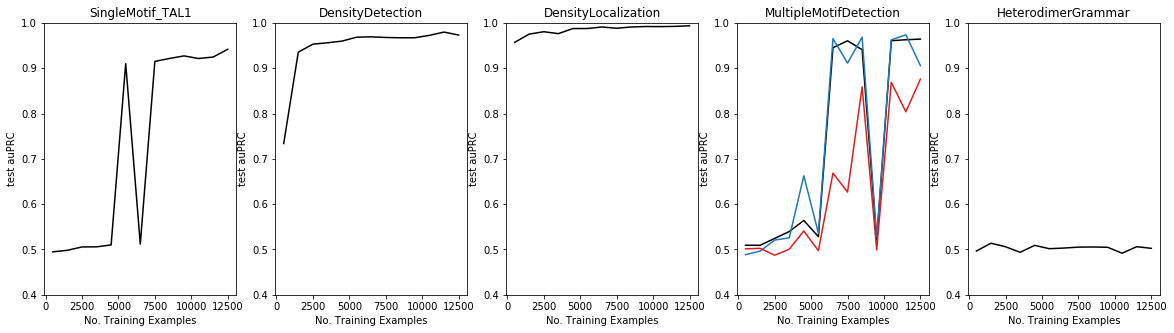

In [32]:
hyperparam_plot_test_auPRC(training_examples_grid,
                           training_examples_test_auPRC,
                           "No. Training Examples",
                           "test auPRC")


### Convolutional Filter Width<a name='4b'>
<a href=#outline>Home</a>


In [33]:
#Define grid of possible parameter values 
filter_width_grid=range(1,31,5)

filter_width_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    filter_width_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for filter_width in filter_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=15,
                                            kernel_size=filter_width)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3,
                                          kernel_size=filter_width)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          kernel_size=filter_width)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Filter width:"+str(filter_width)+": auPRC:"+str(cur_auPRC))
        filter_width_test_auPRC[name].append(cur_auPRC)
    
   

SingleMotif_TAL1
Filter width:1: auPRC:[0.49800748104050524]
Filter width:6: auPRC:[0.7736353951573001]
Filter width:11: auPRC:[0.9790414857473454]
Filter width:16: auPRC:[0.9288423588604277]
Filter width:21: auPRC:[0.9234429687544926]
Filter width:26: auPRC:[0.9337907163792584]
DensityDetection
Filter width:1: auPRC:[0.4997446209139346]
Filter width:6: auPRC:[0.9792364177826844]
Filter width:11: auPRC:[0.9921738747819965]
Filter width:16: auPRC:[0.9736580785292566]
Filter width:21: auPRC:[0.9706310300964816]
Filter width:26: auPRC:[0.9725438107009712]
DensityLocalization
Filter width:1: auPRC:[0.4972715150169211]
Filter width:6: auPRC:[0.9815075742342986]
Filter width:11: auPRC:[0.992577320412669]
Filter width:16: auPRC:[0.9942391703404929]
Filter width:21: auPRC:[0.9937214834555276]
Filter width:26: auPRC:[0.9911938209693699]
MultipleMotifDetection
Filter width:1: auPRC:[0.49880123957318645, 0.49973112126147146, 0.5003289111758003]
Filter width:6: auPRC:[0.622654696143972, 0.52587941

Plot the results of the parameter grid search:

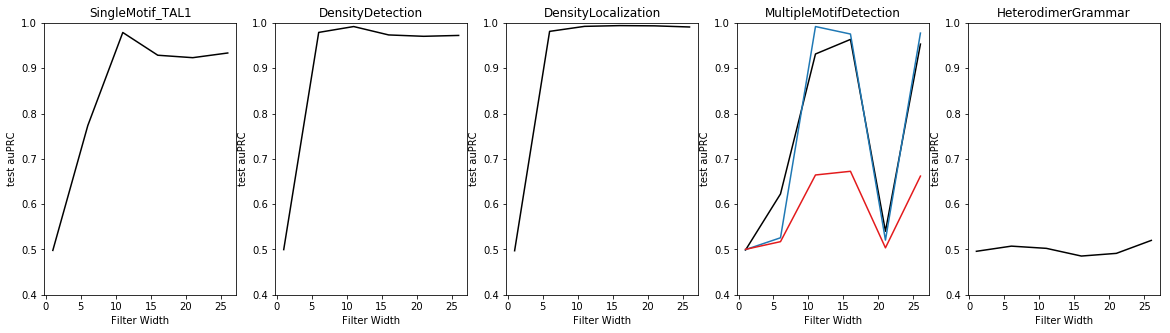

In [34]:
hyperparam_plot_test_auPRC(filter_width_grid,
                           filter_width_test_auPRC,
                           "Filter Width",
                           "test auPRC")

### Number of convolution filters<a name='4c'>
<a href=#outline>Home</a>


In [35]:
#Define grid of possible parameter values 
num_filters_grid=range(1,41,5)

num_filters_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    num_filters_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for num_filters in num_filters_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=num_filters)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_tasks=3,
                                            num_filters=num_filters)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          num_filters=num_filters)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Number of Conv. Filters:"+str(num_filters)+": auPRC:"+str(cur_auPRC))
        num_filters_test_auPRC[name].append(cur_auPRC)

SingleMotif_TAL1
Number of Conv. Filters:1: auPRC:[0.4972077982634246]
Number of Conv. Filters:6: auPRC:[0.9275896433517322]
Number of Conv. Filters:11: auPRC:[0.926396807169318]
Number of Conv. Filters:16: auPRC:[0.9317213168651434]
Number of Conv. Filters:21: auPRC:[0.9243475341093395]
Number of Conv. Filters:26: auPRC:[0.9190529015721385]
Number of Conv. Filters:31: auPRC:[0.9186963758131524]
Number of Conv. Filters:36: auPRC:[0.9170528820707297]
DensityDetection
Number of Conv. Filters:1: auPRC:[0.5140851003616058]
Number of Conv. Filters:6: auPRC:[0.9698952683242931]
Number of Conv. Filters:11: auPRC:[0.966812969007504]
Number of Conv. Filters:16: auPRC:[0.9752598541576665]
Number of Conv. Filters:21: auPRC:[0.9737175794812718]
Number of Conv. Filters:26: auPRC:[0.9728855661690587]
Number of Conv. Filters:31: auPRC:[0.9726043116689866]
Number of Conv. Filters:36: auPRC:[0.9712337897406358]
DensityLocalization
Number of Conv. Filters:1: auPRC:[0.9946508189456394]
Number of Conv. Fi

Plot the results of the parameter grid search:

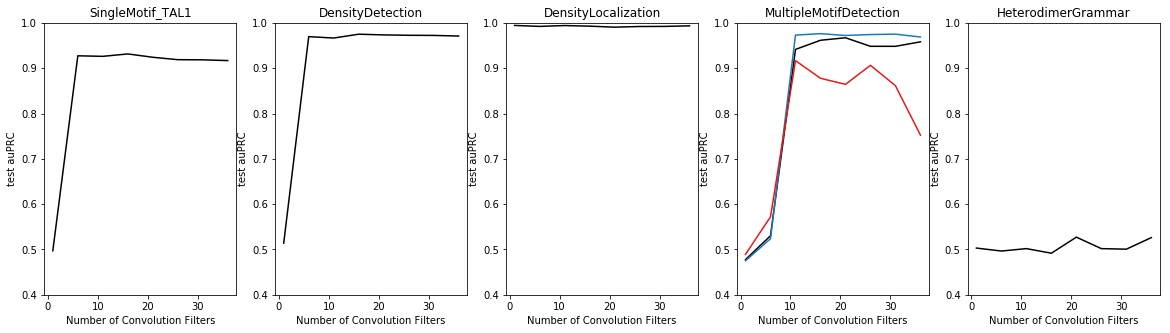

In [36]:
hyperparam_plot_test_auPRC(num_filters_grid,
                           num_filters_test_auPRC,
                           "Number of Convolution Filters",
                           "test auPRC")

### Max Pooling Width <a name='4d'>
<a href=#outline>Home</a>

In [37]:
#Define grid of possible parameter values 
pool_width_grid=range(5,55,10)

pool_width_test_auPRC=dict()
#Iterate through all data simulations 
for name in dataset_names: 
    print(name)
    
    #Create a list to store test auPRC values for the dataset/hyperparam combination 
    pool_width_test_auPRC[name]=[] 
    
    #Iterate through all values of the hyperparameter in the grid
    for pool_width in pool_width_grid:         
        #Define the model architecture to account for the specifics of the current dataset. Leave all "standard"
        #parameter values at their defaults. See help(hyperparam_get_model)
        
        if name=="HeterodimerGrammar":
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                            num_layers=3,
                                            num_filters=15,
                                            pool_size=pool_width)
        elif name=="MultipleMotifDetection": 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                             num_tasks=3,
                                          pool_size=pool_width)
        else: 
            cur_model=hyperparam_get_model(datasets[name].X_train.shape[1::],
                                          pool_size=pool_width)
            
        #Perform grid search for the current dataset 
        cur_auPRC=hyperparam_train_model(datasets[name],cur_model)
        print("Max Pool Size:"+str(pool_width)+": auPRC:"+str(cur_auPRC))
        pool_width_test_auPRC[name].append(cur_auPRC)

SingleMotif_TAL1
Max Pool Size:5: auPRC:[0.9328297719510235]
Max Pool Size:15: auPRC:[0.9417720430301089]
Max Pool Size:25: auPRC:[0.9397934000731554]
Max Pool Size:35: auPRC:[0.9159256756300642]
Max Pool Size:45: auPRC:[0.9193901759402117]
DensityDetection
Max Pool Size:5: auPRC:[0.9701106467703483]
Max Pool Size:15: auPRC:[0.9853822661162578]
Max Pool Size:25: auPRC:[0.9785564069025103]
Max Pool Size:35: auPRC:[0.9682369917918686]
Max Pool Size:45: auPRC:[0.9723148070369128]
DensityLocalization
Max Pool Size:5: auPRC:[0.985529776249226]
Max Pool Size:15: auPRC:[0.9952000172062114]
Max Pool Size:25: auPRC:[0.9922752113512978]
Max Pool Size:35: auPRC:[0.9949041604019051]
Max Pool Size:45: auPRC:[0.9783206737632285]
MultipleMotifDetection
Max Pool Size:5: auPRC:[0.5488803714876205, 0.5188610462637432, 0.5071087705295587]
Max Pool Size:15: auPRC:[0.9776797214117372, 0.9913345034982631, 0.8336930920727511]
Max Pool Size:25: auPRC:[0.9826271246541552, 0.9884974068818977, 0.8604129874925174

Plot the results of the parameter grid search:

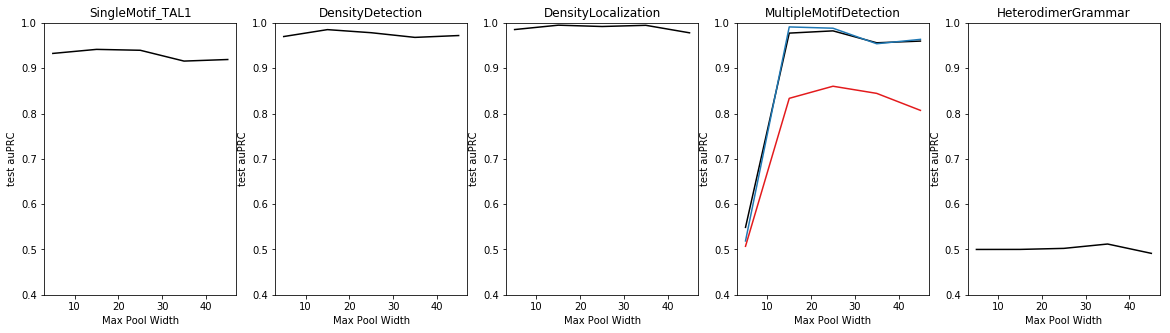

In [38]:
hyperparam_plot_test_auPRC(pool_width_grid,
                           pool_width_test_auPRC,
                           "Max Pool Width",
                           "test auPRC")

## Conclusions<a name='5'>
<a href=#outline>Home</a>

* To fully convince ourselves that the hyperparameters we have found for each dataset are truly optimal, we should repeat this experiment several times and use the average test auPRC for each hyperparameter setting. What happens if your run each parameter tuning step 5 times? 10 times? Do the optimal parameter values we have found  hold?


* We performed parameter grid search "manually" to illustrate how this process works. However, a number of Python packages are available to automate this task. A few notable ones are: 

     * kopt (https://github.com/Avsecz/kopt). A tutorial is available (https://i12g-gagneurweb.in.tum.de/public/docs/concise/tutorials/hyper-parameter_optimization/)
     * Hyperas (https://github.com/maxpumperla/hyperas)
     * Hyperopt (https://github.com/hyperopt/hyperopt)  
     * MOE (https://github.com/Yelp/MOE) 
     
* In this tutorial, we performed a grid search 